In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import os
N = 4096
H = 2048
import sys
sys.path.append('..')

In [17]:
def normalize_feature_sequence(X, norm='2', threshold=0.0001, v=None):
    """Normalizes the columns of a feature sequence

    Notebook: C3/C3S1_FeatureNormalization.ipynb

    Args:
        X (np.ndarray): Feature sequence
        norm (str): The norm to be applied. '1', '2', 'max' or 'z' (Default value = '2')
        threshold (float): An threshold below which the vector ``v`` used instead of normalization
            (Default value = 0.0001)
        v (float): Used instead of normalization below ``threshold``. If None, uses unit vector for given norm
            (Default value = None)

    Returns:
        X_norm (np.ndarray): Normalized feature sequence
    """
    assert norm in ['1', '2', 'max', 'z']

    K, N = X.shape
    X_norm = np.zeros((K, N))

    if norm == '1':
        if v is None:
            v = np.ones(K, dtype=np.float64) / K
        for n in range(N):
            s = np.sum(np.abs(X[:, n]))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v

    if norm == '2':
        if v is None:
            v = np.ones(K, dtype=np.float64) / np.sqrt(K)
        for n in range(N):
            s = np.sqrt(np.sum(X[:, n] ** 2))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v

    if norm == 'max':
        if v is None:
            v = np.ones(K, dtype=np.float64)
        for n in range(N):
            s = np.max(np.abs(X[:, n]))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v

    if norm == 'z':
        if v is None:
            v = np.zeros(K, dtype=np.float64)
        for n in range(N):
            mu = np.sum(X[:, n]) / K
            sigma = np.sqrt(np.sum((X[:, n] - mu) ** 2) / (K - 1))
            if sigma > threshold:
                X_norm[:, n] = (X[:, n] - mu) / sigma
            else:
                X_norm[:, n] = v

    return X_norm

In [3]:
def plot_matrix(X, Fs=1, Fs_F=1, T_coef=None, F_coef=None, xlabel='Time (seconds)', ylabel='Frequency (Hz)',
                xlim=None, ylim=None, clim=None, title='', dpi=72,
                colorbar=True, colorbar_aspect=20.0, cbar_label='', ax=None, figsize=(6, 3), **kwargs):
    """2D raster visualization of a matrix, e.g. a spectrogram or a tempogram.

    Args:
        X: The matrix
        Fs: Sample rate for axis 1 (Default value = 1)
        Fs_F: Sample rate for axis 0 (Default value = 1)
        T_coef: Time coeffients. If None, will be computed, based on Fs. (Default value = None)
        F_coef: Frequency coeffients. If None, will be computed, based on Fs_F. (Default value = None)
        xlabel: Label for x-axis (Default value = 'Time (seconds)')
        ylabel: Label for y-axis (Default value = 'Frequency (Hz)')
        xlim: Limits for x-axis (Default value = None)
        ylim: Limits for y-axis (Default value = None)
        clim: Color limits (Default value = None)
        title: Title for plot (Default value = '')
        dpi: Dots per inch (Default value = 72)
        colorbar: Create a colorbar. (Default value = True)
        colorbar_aspect: Aspect used for colorbar, in case only a single axes is used. (Default value = 20.0)
        cbar_label: Label for colorbar (Default value = '')
        ax: Either (1.) a list of two axes (first used for matrix, second for colorbar), or (2.) a list with a single
            axes (used for matrix), or (3.) None (an axes will be created). (Default value = None)
        figsize: Width, height in inches (Default value = (6, 3))
        **kwargs: Keyword arguments for matplotlib.pyplot.imshow

    Returns:
        fig: The created matplotlib figure or None if ax was given.
        ax: The used axes.
        im: The image plot
    """
    fig = None
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
        ax = [ax]
    if T_coef is None:
        T_coef = np.arange(X.shape[1]) / Fs
    if F_coef is None:
        F_coef = np.arange(X.shape[0]) / Fs_F

    if 'extent' not in kwargs:
        x_ext1 = (T_coef[1] - T_coef[0]) / 2
        x_ext2 = (T_coef[-1] - T_coef[-2]) / 2
        y_ext1 = (F_coef[1] - F_coef[0]) / 2
        y_ext2 = (F_coef[-1] - F_coef[-2]) / 2
        kwargs['extent'] = [T_coef[0] - x_ext1, T_coef[-1] + x_ext2, F_coef[0] - y_ext1, F_coef[-1] + y_ext2]
    if 'cmap' not in kwargs:
        kwargs['cmap'] = 'gray_r'
    if 'aspect' not in kwargs:
        kwargs['aspect'] = 'auto'
    if 'origin' not in kwargs:
        kwargs['origin'] = 'lower'
    if 'interpolation' not in kwargs:
        kwargs['interpolation'] = 'nearest'

    im = ax[0].imshow(X, **kwargs)

    if len(ax) == 2 and colorbar:
        cbar = plt.colorbar(im, cax=ax[1])
        cbar.set_label(cbar_label)
    elif len(ax) == 2 and not colorbar:
        ax[1].set_axis_off()
    elif len(ax) == 1 and colorbar:
        plt.sca(ax[0])
        cbar = plt.colorbar(im, aspect=colorbar_aspect)
        cbar.set_label(cbar_label)

    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)
    ax[0].set_title(title)
    if xlim is not None:
        ax[0].set_xlim(xlim)
    if ylim is not None:
        ax[0].set_ylim(ylim)
    if clim is not None:
        im.set_clim(clim)

    if fig is not None:
        plt.tight_layout()

    return fig, ax, im


In [4]:
def plot_chromagram(*args, chroma_yticks=np.arange(12), **kwargs):
    """Call libfmp.b.plot_matrix and sets chroma labels.

    See :func:`libfmp.b.b_plot.plot_matrix` for parameters and return values.
    """
    if 'ylabel' not in kwargs:
        kwargs['ylabel'] = 'Chroma'
    fig, ax, im = plot_matrix(*args, **kwargs)

    chroma_names = 'C C# D D# E F F# G G# A A# B'.split()
    ax[0].set_yticks(np.array(chroma_yticks))
    ax[0].set_yticklabels([chroma_names[i] for i in chroma_yticks])

    return fig, ax, im
    

In [28]:
def chromagram_from_file(fn_wav, Fs=22050, N=4096, H=2048, gamma=None, version='CQT', norm='2'):
    """Compute chromagram for WAV file specified by filename
    Args:
        fn_wav (str): Directory of WAV
        Fs (scalar): Sampling rate (Default value = 22050)
        N (int): Window size (Default value = 4096)
        H (int): Hop size (Default value = 2048)
        gamma (float): Constant for logarithmic compression (Default value = None)
        version (str): What Chroma version to use ('STFT', 'IIS', 'CQT') (Default value = 'CQT')
        norm (str): If not 'None', chroma vectors are normalized by norm as specified ('1', '2', 'max')
            (Default value = '2')

    Returns:
        X (np.ndarray): Chromagram
        Fs_X (scalar): Feature reate of chromagram
        x (np.ndarray): Audio signal
        Fs (scalar): Sampling rate of audio signal
        x_dur (float): Duration (seconds) of audio signal"""
    
    #load audio
    x, Fs = librosa.load(fn_wav, sr=Fs)
    x_dur = x.shape[0] / Fs
    
    """ 
    #* Compute STFT Chromogram (along with STFT spectrogram)
    #?    Werid Args:
    #?     N (int, optional): The FFT window size. Determines the number of frequency bins in the STFT.
    #?     H (int, optional): Hop length. Number of audio samples between successive STFT columns.
    #?     gamma (float, optional): Used for logarithmic compression of the magnitude spectrum. If specified, applies logarithmic compression with this scaling factor. If None, uses squared magnitude.
    #?     norm (str): If not 'None', chroma vectors are normalized by norm as specified ('1', '2', 'max')
    #?         (Default value = '2')      
    """
    if version == 'STFT':
        X =librosa.stft(x, n_fft=N, hop_length=H, center=True, pad_mode='constant') #STFT spectrogram
        if gamma is not None: #logarithmic compression
            X = np.log(1 + gamma * np.abs(X)**2)
        else:
            X = np.abs(X)**2
            
        X = librosa.feature.chroma_stft(S=X, sr=Fs, tuning=0, norm=None, hop_length=H, n_fft=N) #STFT chromagram
        
    #* Compute CQT Chromogram 
    if version == 'CQT':
        X = librosa.feature.chroma_cqt(y=x, sr=Fs, hop_length=H, norm=None)
        
    #* Compute IIR Chromogram 
    if version == 'IIR':
        X = librosa.iirt(x, sr=Fs, win_length=N, hop_length=H, center=True, tuning=0.0)
        if gamma is not None:
            X = np.log(1 + gamma * np.abs(X)**2)
        X = librosa.feature.chroma_cqt(C=X, bins_per_octave=12, n_octaves=7,
                                       fmin=librosa.midi_to_hz(24), norm=None)
        
    if norm is not None:
        X = normalize_feature_sequence(X, norm=norm)
        
    Fs_X = Fs /H
    return X, Fs_X, x, Fs, x_dur
                
    Fs_X = Fs / H
    return X, Fs_X, x, Fs, x_dur
        

In [29]:
c2 = "/home/dofo/Desktop/music/chords/major_triad/major_triad36.wav"
c3 = "/home/dofo/Desktop/music/chords/major_triad/major_triad48.wav"
c4 = "/home/dofo/Desktop/music/chords/major_triad/major_triad60.wav"
c5 = "/home/dofo/Desktop/music/chords/major_triad/major_triad72.wav"
c6 = "/home/dofo/Desktop/music/chords/major_triad/major_triad84.wav"
c7 = "/home/dofo/Desktop/music/chords/major_triad/major_triad96.wav"

In [30]:
c2 = "/home/dofo/Desktop/music/chords/major_triad/D274_major_triad36.wav"
c3 = "/home/dofo/Desktop/music/chords/major_triad/D274_major_triad48.wav"
c4 = "/home/dofo/Desktop/music/chords/major_triad/D274_major_triad60.wav"
c5 = "/home/dofo/Desktop/music/chords/major_triad/D274_major_triad72.wav"
c6 = "/home/dofo/Desktop/music/chords/major_triad/D274_major_triad84.wav"
c7 = "/home/dofo/Desktop/music/chords/major_triad/D274_major_triad96.wav"

In [31]:
X2_STFT, Fs_X, x, Fs, x_dur = chromagram_from_file(c2, N=N, H=H, gamma=0.1, version='STFT', norm='2')
X2_CQT, Fs_X, x, Fs, x_dur = chromagram_from_file(c2, N=N, H=H, gamma=0.1, version='CQT', norm='2')
X2_IIR, Fs_X, x, Fs, x_dur = chromagram_from_file(c2, N=N, H=H, gamma=0.1, version='IIR', norm='2')

X3_STFT, Fs_X, x, Fs, x_dur = chromagram_from_file(c3, N=N, H=H, gamma=0.1, version='STFT', norm='2')
X3_CQT, Fs_X, x, Fs, x_dur = chromagram_from_file(c3, N=N, H=H, gamma=0.1, version='CQT', norm='2')
X3_IIR, Fs_X, x, Fs, x_dur = chromagram_from_file(c3, N=N, H=H, gamma=0.1, version='IIR',  norm='2')

X4_STFT, Fs_X, x, Fs, x_dur = chromagram_from_file(c4, N=N, H=H, gamma=0.1, version='STFT', norm='2')
X4_CQT, Fs_X, x, Fs, x_dur = chromagram_from_file(c4, N=N, H=H, gamma=0.1, version='CQT', norm='2')
X4_IIR, Fs_X, x, Fs, x_dur = chromagram_from_file(c4, N=N, H=H, gamma=0.1, version='IIR', norm='2')

X5_STFT, Fs_X, x, Fs, x_dur = chromagram_from_file(c5, N=N, H=H, gamma=0.1, version='STFT', norm='2')
X5_CQT, Fs_X, x, Fs, x_dur = chromagram_from_file(c5, N=N, H=H, gamma=0.1, version='CQT', norm='2')
X5_IIR, Fs_X, x, Fs, x_dur = chromagram_from_file(c5, N=N, H=H, gamma=0.1, version='IIR', norm='2')

X6_STFT, Fs_X, x, Fs, x_dur = chromagram_from_file(c6, N=N, H=H, gamma=0.1, version='STFT', norm='2')
X6_CQT, Fs_X, x, Fs, x_dur = chromagram_from_file(c6, N=N, H=H, gamma=0.1, version='CQT', norm='2')
X6_IIR, Fs_X, x, Fs, x_dur = chromagram_from_file(c6, N=N, H=H, gamma=0.1, version='IIR', norm='2')

X7_STFT, Fs_X, x, Fs, x_dur = chromagram_from_file(c7, N=N, H=H, gamma=0.1, version='STFT', norm='2')
X7_CQT, Fs_X, x, Fs, x_dur = chromagram_from_file(c7, N=N, H=H, gamma=0.1, version='CQT', norm='2')
X7_IIR, Fs_X, x, Fs, x_dur = chromagram_from_file(c7, N=N, H=H, gamma=0.1, version='IIR', norm='2')

(<Figure size 432x216 with 2 Axes>,
 [<Axes: title={'center': 'CQT c7'}, xlabel='Time (seconds)', ylabel='Chroma'>],
 <matplotlib.image.AxesImage at 0x7f1d39d816d0>)

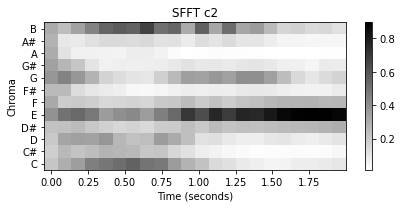

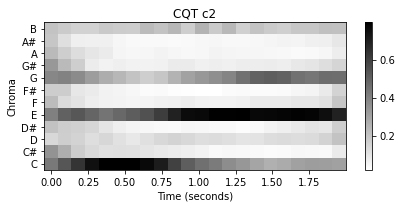

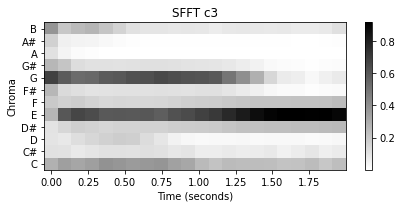

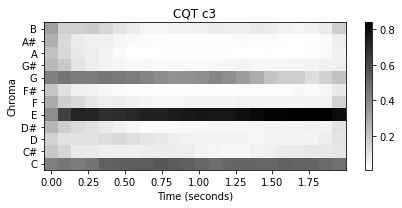

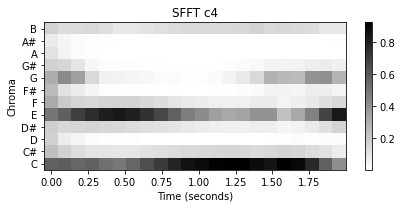

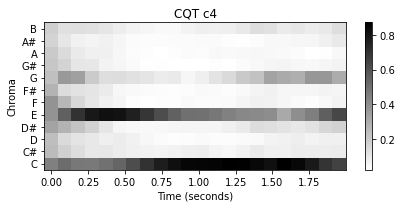

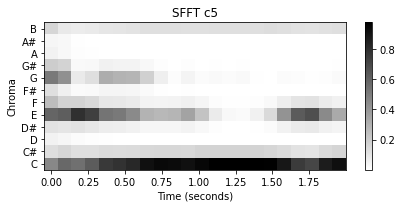

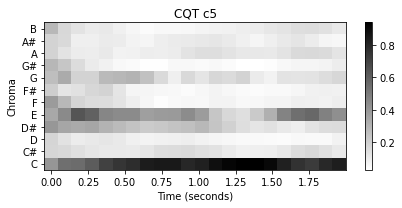

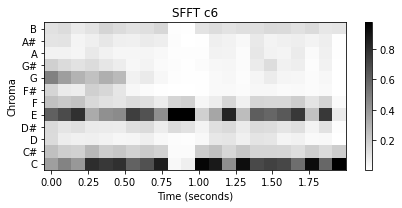

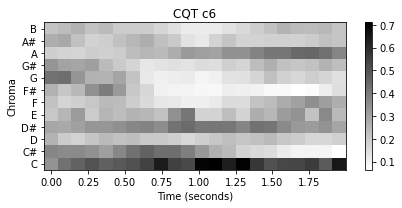

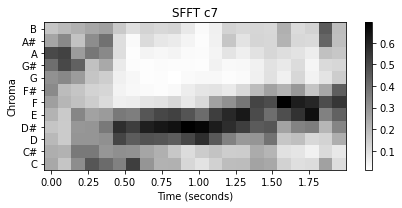

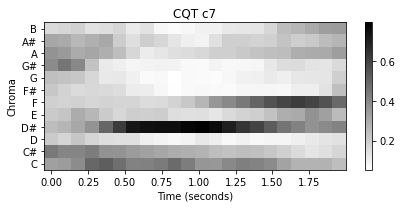

In [33]:
plot_chromagram(X2_STFT, Fs=Fs_X, title="SFFT c2")
plot_chromagram(X2_CQT, Fs=Fs_X, title="CQT c2")

plot_chromagram(X3_STFT, Fs=Fs_X, title="SFFT c3")
plot_chromagram(X3_CQT, Fs=Fs_X, title="CQT c3")

plot_chromagram(X4_STFT, Fs=Fs_X, title="SFFT c4")
plot_chromagram(X4_CQT, Fs=Fs_X, title="CQT c4")

plot_chromagram(X5_STFT, Fs=Fs_X, title="SFFT c5")
plot_chromagram(X5_CQT, Fs=Fs_X, title="CQT c5")

plot_chromagram(X6_STFT, Fs=Fs_X, title="SFFT c6")
plot_chromagram(X6_CQT, Fs=Fs_X, title="CQT c6")

plot_chromagram(X7_STFT, Fs=Fs_X, title="SFFT c7")
plot_chromagram(X7_CQT, Fs=Fs_X, title="CQT c7")


In [23]:
X2_STFT, Fs_X, x, Fs, x_dur = chromagram_from_file(c2, N=N, H=H, gamma=0.1, version='STFT', norm=None)
X2_CQT, Fs_X, x, Fs, x_dur = chromagram_from_file(c2, N=N, H=H, gamma=0.1, version='CQT', norm=None)
X2_IIR, Fs_X, x, Fs, x_dur = chromagram_from_file(c2, N=N, H=H, gamma=0.1, version='IIR', norm=None)

X3_STFT, Fs_X, x, Fs, x_dur = chromagram_from_file(c3, N=N, H=H, gamma=0.1, version='STFT', norm=   None)
X3_CQT, Fs_X, x, Fs, x_dur = chromagram_from_file(c3, N=N, H=H, gamma=0.1, version='CQT', norm=None)
X3_IIR, Fs_X, x, Fs, x_dur = chromagram_from_file(c3, N=N, H=H, gamma=0.1, version='IIR',  norm=None)

X4_STFT, Fs_X, x, Fs, x_dur = chromagram_from_file(c4, N=N, H=H, gamma=0.1, version='STFT', norm=   None)
X4_CQT, Fs_X, x, Fs, x_dur = chromagram_from_file(c4, N=N, H=H, gamma=0.1, version='CQT', norm=None)
X4_IIR, Fs_X, x, Fs, x_dur = chromagram_from_file(c4, N=N, H=H, gamma=0.1, version='IIR', norm=None)

X5_STFT, Fs_X, x, Fs, x_dur = chromagram_from_file(c5, N=N, H=H, gamma=0.1, version='STFT', norm=None)
X5_CQT, Fs_X, x, Fs, x_dur = chromagram_from_file(c5, N=N, H=H, gamma=0.1, version='CQT', norm=None)
X5_IIR, Fs_X, x, Fs, x_dur = chromagram_from_file(c5, N=N, H=H, gamma=0.1, version='IIR', norm=None)

X6_STFT, Fs_X, x, Fs, x_dur = chromagram_from_file(c6, N=N, H=H, gamma=0.1, version='STFT', norm=None)
X6_CQT, Fs_X, x, Fs, x_dur = chromagram_from_file(c6, N=N, H=H, gamma=0.1, version='CQT', norm=None)
X6_IIR, Fs_X, x, Fs, x_dur = chromagram_from_file(c6, N=N, H=H, gamma=0.1, version='IIR', norm=None)

X7_STFT, Fs_X, x, Fs, x_dur = chromagram_from_file(c7, N=N, H=H, gamma=0.1, version='STFT', norm=None)
X7_CQT, Fs_X, x, Fs, x_dur = chromagram_from_file(c7, N=N, H=H, gamma=0.1, version='CQT', norm=None)
X7_IIR, Fs_X, x, Fs, x_dur = chromagram_from_file(c7, N=N, H=H, gamma=0.1, version='IIR', norm=None)

(<Figure size 432x216 with 2 Axes>,
 [<Axes: title={'center': 'CQT c7'}, xlabel='Time (seconds)', ylabel='Chroma'>],
 <matplotlib.image.AxesImage at 0x7f1d9832d590>)

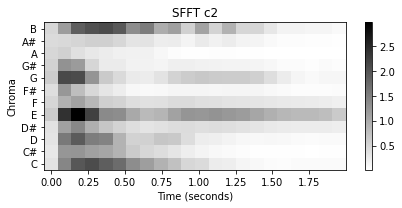

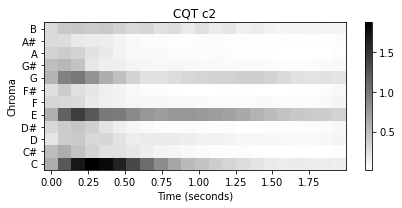

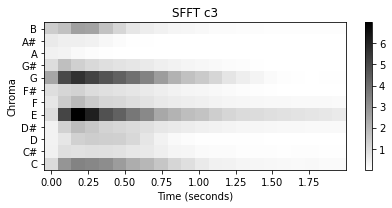

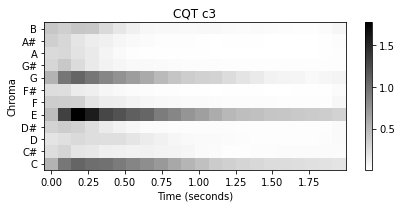

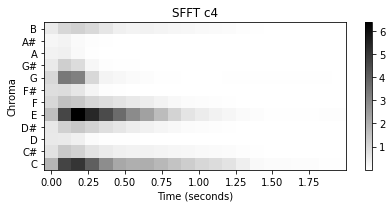

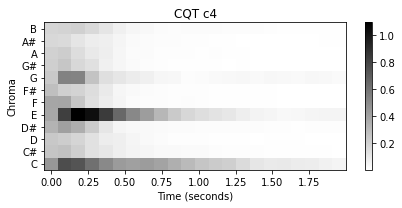

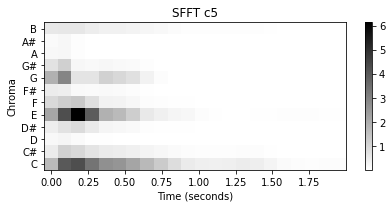

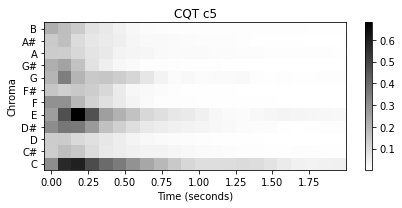

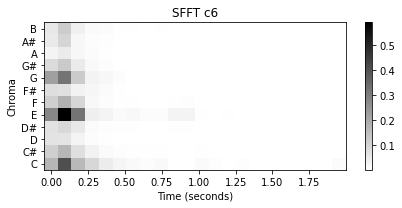

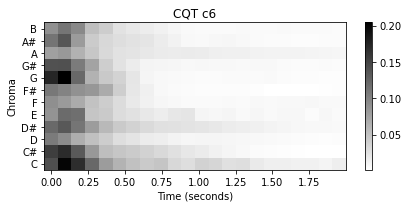

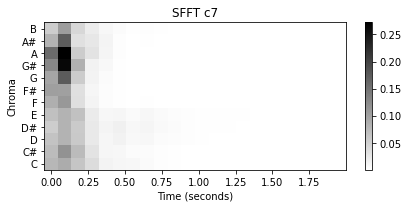

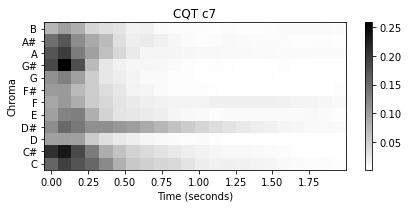

In [24]:
plot_chromagram(X2_STFT, Fs=Fs_X, title="SFFT c2")
plot_chromagram(X2_CQT, Fs=Fs_X, title="CQT c2")

plot_chromagram(X3_STFT, Fs=Fs_X, title="SFFT c3")
plot_chromagram(X3_CQT, Fs=Fs_X, title="CQT c3")

plot_chromagram(X4_STFT, Fs=Fs_X, title="SFFT c4")
plot_chromagram(X4_CQT, Fs=Fs_X, title="CQT c4")

plot_chromagram(X5_STFT, Fs=Fs_X, title="SFFT c5")
plot_chromagram(X5_CQT, Fs=Fs_X, title="CQT c5")

plot_chromagram(X6_STFT, Fs=Fs_X, title="SFFT c6")
plot_chromagram(X6_CQT, Fs=Fs_X, title="CQT c6")

plot_chromagram(X7_STFT, Fs=Fs_X, title="SFFT c7")
plot_chromagram(X7_CQT, Fs=Fs_X, title="CQT c7")